In [2]:
import torch
import math
import glob
import cv2
import numpy as np 
from PIL import Image
import mediapipe as mp

from diffusers.utils import make_image_grid
from IPython.display import Image as DImage

from insightface.app import FaceAnalysis


import os
import gdown
import insightface
import matplotlib.pyplot as plt
from codeformer.app import inference_app
import shutil


from diffusers import StableDiffusionXLPipeline, DDIMScheduler, AutoencoderKL, StableDiffusionXLControlNetPipeline, ControlNetModel, UniPCMultistepScheduler, StableDiffusionXLControlNetInpaintPipeline, StableDiffusionXLInpaintPipeline
from diffusers.utils import make_image_grid
from controlnet_aux import OpenposeDetector

from ip_adapter.ip_adapter_faceid_separate import IPAdapterFaceIDXL
from PIL import Image, ImageDraw, ImageFont

In [3]:
def find_closest_dimensions(width:int, height: int, factor: int = 8):
    # Function to round a number to the nearest multiple of 8
    def round_to_nearest(n):
        return n - (n % factor)
    
    closest_width = round_to_nearest(width)
    closest_height = round_to_nearest(height)

    return closest_width, closest_height

def resize_to_allowed_dimensions(width, height, mult_factor=1.0):
    """
    Function re-used from Lucataco's implementation of SDXL-Controlnet for Replicate
    """
    # List of SDXL dimensions
    allowed_dimensions = [
        (512, 2048), (512, 1984), (512, 1920), (512, 1856),
        (576, 1792), (576, 1728), (576, 1664), (640, 1600),
        (640, 1536), (704, 1472), (704, 1408), (704, 1344),
        (768, 1344), (768, 1280), (832, 1216), (832, 1152),
        (896, 1152), (896, 1088), (960, 1088), (960, 1024),
        (1024, 1024), (1024, 960), (1088, 960), (1088, 896),
        (1152, 896), (1152, 832), (1216, 832), (1280, 768),
        (1344, 768), (1408, 704), (1472, 704), (1536, 640),
        (1600, 640), (1664, 576), (1728, 576), (1792, 576),
        (1856, 512), (1920, 512), (1984, 512), (2048, 512)
    ]
    # Calculate the aspect ratio
    aspect_ratio = width / height
    print(f"Aspect Ratio: {aspect_ratio:.2f}")
    # Find the closest allowed dimensions that maintain the aspect ratio
    closest_dimensions = min(
        allowed_dimensions,
        key=lambda dim: abs(dim[0] / dim[1] - aspect_ratio)
    )

    closest_dimensions = find_closest_dimensions(
        int(closest_dimensions[0]*mult_factor), 
        int(closest_dimensions[1]*mult_factor)
    )
    return closest_dimensions




mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def calculate_orientation_score(landmarks):
    # Define points for horizontal and vertical angles
    left_eye_outer = landmarks[33]
    right_eye_outer = landmarks[263]
    nose_tip = landmarks[1]
    chin_center = landmarks[152]
    left_ear = landmarks[234]
    right_ear = landmarks[454]

    # Calculate horizontal angle
    horizontal_angle = np.arctan2(right_eye_outer.y - left_eye_outer.y, right_eye_outer.x - left_eye_outer.x)

    # Calculate vertical angle
    nose_to_chin_vector = np.array([nose_tip.x, nose_tip.y]) - np.array([chin_center.x, chin_center.y])
    vertical_angle = np.arctan2(nose_to_chin_vector[1], nose_to_chin_vector[0])

    # Calculate roll angle (tilt)
    left_to_right_ear_vector = np.array([right_ear.x, right_ear.y]) - np.array([left_ear.x, left_ear.y])
    roll_angle = np.arctan2(left_to_right_ear_vector[1], left_to_right_ear_vector[0])

    print(f"Horizontal angle: {horizontal_angle}, Vertical angle: {vertical_angle}, Roll angle: {roll_angle}")

    # The closer the angles are to 0, the more frontal the face is
    score = 1 / (np.abs(horizontal_angle) + np.abs(vertical_angle) + np.abs(roll_angle) + 1e-6)
    return score

def process_image(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process image with MediaPipe Face Mesh
    results = face_mesh.process(rgb_image)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks = face_landmarks.landmark
            return calculate_orientation_score(landmarks)
    return 0

def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  return img

def segment(model_path, paths, label):

    inputs = []
    masks = []
    outputs = []
    image_paths = []

    
    for image_path in paths:
        image_paths.append(image_path)
        pil_img = Image.open(image_path)
        inputs.append(pil_img)
        image = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(pil_img)        
        )
        # Create a image segmenter instance with the image mode:
        options = ImageSegmenterOptions(
            base_options=BaseOptions(model_asset_path=model_path),
            running_mode=VisionRunningMode.IMAGE,
            output_category_mask=True)
        with ImageSegmenter.create_from_options(options) as segmenter:
            segmented_masks = segmenter.segment(image)
            category_mask = segmented_masks.category_mask
            
            # Generate solid color images for showing the output segmentation mask.
            image_data = image.numpy_view()
            fg_image = np.zeros(image_data.shape, dtype=np.uint8)
            fg_image[:] = MASK_COLOR
            bg_image = np.zeros(image_data.shape, dtype=np.uint8)
            bg_image[:] = BG_COLOR
        
            condition = (np.stack((category_mask.numpy_view(),) * 3, axis=-1) >= label - 0.2) & (np.stack((category_mask.numpy_view(),) * 3, axis=-1) <= label+0.2)
            output_image = np.where(condition, fg_image, bg_image)
            print(output_image.shape)
        
            outputs.append(output_image)
            out = resize_and_show(output_image)
            
            masks.append(Image.fromarray(out))

    return outputs


def blur_mask(mask_image: Image, blur_value: int):
    np_mask = np.array(mask_image)
    kernel_size = 2 * int(2 * blur_value) + 1
    np_mask = cv2.GaussianBlur(np_mask, (kernel_size, 1), blur_value)
    image_mask = Image.fromarray(np_mask)

    np_mask = np.array(image_mask)
    kernel_size = 2 * int(2 * blur_value) + 1
    np_mask = cv2.GaussianBlur(np_mask, (1, kernel_size), blur_value)
    image_mask = Image.fromarray(np_mask)
    
    return image_mask


def expand_white_area(mask, expansion_size=10):

    mask = np.array(mask)
    print(np.min(mask), np.max(mask))
    """
    Expand the white area of a binary mask by a specified number of pixels.

    Parameters:
    - mask: 2D numpy array of the binary mask (black and white values)
    - expansion_size: The number of pixels to expand the white area (default is 10 pixels)

    Returns:
    - expanded_mask: The binary mask with the expanded white area
    """
    # Define the kernel size for dilation
    kernel_size = (expansion_size, expansion_size)
    kernel = np.ones(kernel_size, np.uint8)
    
    # Dilate the white regions of the mask
    expanded_mask = cv2.dilate(mask, kernel, iterations=1)
    
    return Image.fromarray(expanded_mask)


### Generating initial images with poses

In [4]:
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-openpose-sdxl-1.0", torch_dtype=torch.float16)


from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionXLPipeline, 
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLImg2ImgPipeline,
    ControlNetModel,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    HeunDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    PNDMScheduler
)

class KarrasDPM:
    def from_config(config):
        return DPMSolverMultistepScheduler.from_config(config, use_karras_sigmas=True)


class DPMPPSDEKarras:
    def from_config(config):
        return DPMSolverMultistepScheduler.from_config(
            config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++"
        )

device = "cuda"

SCHEDULERS = {
    "DDIM": DDIMScheduler,
    "DPMSolverMultistep": DPMSolverMultistepScheduler,
    "HeunDiscrete": HeunDiscreteScheduler,
    "KarrasDPM": KarrasDPM,
    "K_EULER_ANCESTRAL": EulerAncestralDiscreteScheduler,
    "K_EULER": EulerDiscreteScheduler,
    "PNDM": PNDMScheduler,
    "DPM++SDEKarras": DPMPPSDEKarras,
}

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718917442.744410    5061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718917442.756675    5083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
DESIRED_HEIGHT = 256
DESIRED_WIDTH = 256

FACE_SKIN_LABEL = 3
BG_COLOR = (0, 0, 0) # gray
MASK_COLOR = (255, 255, 255) # white

model_path_hair = "./models/hair_segmenter.tflite"
model_path_selfie = "./models/selfie_segmenter.tflite"
multi_label = "./models/selfie_multiclass_256x256.tflite"

BaseOptions = mp.tasks.BaseOptions
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [190]:
faces = segment(multi_label, ["input_images/w.jpeg", "input_images/w1.webp"], FACE_SKIN_LABEL)

I0000 00:00:1718925040.876755    4848 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718925040.906120    6407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1158, 1170, 3)


I0000 00:00:1718925041.270913    4848 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718925041.300350    6410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1000, 800, 3)


In [193]:
face_mask = np.array(Image.fromarray(faces[0]).convert("L"))//255

alpha_channel = (face_mask * 255).astype(np.uint8)

image = Image.open("input_images/w.jpeg").convert("RGBA")
# Combine the original image with the alpha channel
image_array = np.array(image)
image_array[..., 3] = alpha_channel

Image.fromarray(image_array).save("input_images/w2_masked.png")

In [197]:
app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

images = ["input_images/w.jpeg", "input_images/w1.webp"]

faceid_embeds = []
for image_path in images:
    image = cv2.imread(image_path)
    faces = app.get(image)
    faceid_embeds.append(torch.from_numpy(faces[0].normed_embedding).unsqueeze(0).unsqueeze(0))

faceid_embeds = torch.cat(faceid_embeds, dim=1)

2024-06-20 23:18:04.409962000 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-06-20 23:18:04.713213844 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0


2024-06-20 23:18:04.960238235 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory

2024-06-20 23:18:05.249936485 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0


2024-06-20 23:18:05.807471231 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [181]:
base_model_path = "SG161222/RealVisXL_V4.0" #"RunDiffusion/Juggernaut-X-v10" #"imagepipeline/Copax-TimeLessXL-SDXL1.0"
ip_ckpt = "ip-adapter-faceid-portrait_sdxl.bin"
device = "cuda"

scheduler = "DPM++SDEKarras"
pipe_maket = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    # variant="fp16",
    feature_extractor=None,
    controlnet = controlnet
).to(device)

pipe_maket.scheduler = SCHEDULERS[scheduler].from_config(pipe_maket.scheduler.config)

# load ip-adapter
ip_model = IPAdapterFaceIDXL(pipe_maket, ip_ckpt, device, num_tokens=16, n_cond=2)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

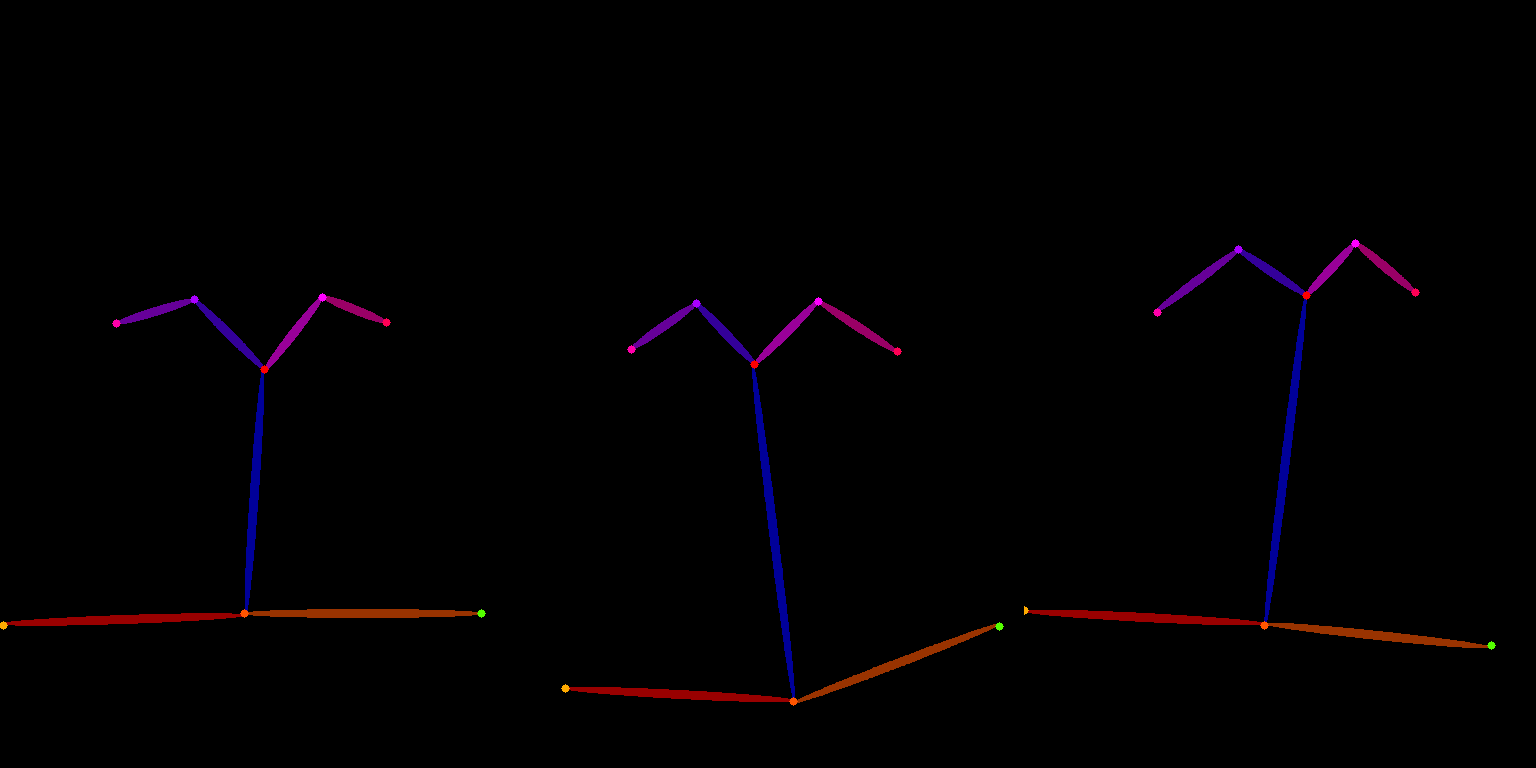

In [244]:
pose_images = [
    openpose(Image.open(p)) for p in glob.glob("poses/gen*")    
]
make_image_grid(pose_images, 1, len(pose_images))

In [183]:
from compel import Compel, ReturnedEmbeddingsType

def add_text(image, text):
    draw = ImageDraw.Draw(image)
    
    # Specify the font and size
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # Update this path to your font file
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)
    
    # Define the text and position
    text = " ".join(text.split("_")).capitalize()
    position = (10, 10)  # (x, y)
    
    # Add text to image
    draw.text(position, text, font=font, fill="black")
    return image


def get_generator(seed, device):

    if seed is not None:
        if isinstance(seed, list):
            generator = [torch.Generator(device).manual_seed(seed_item) for seed_item in seed]
        else:
            generator = torch.Generator(device).manual_seed(seed)
    else:
        generator = None

    return generator

def generate(
    ip_model, 
    faceid_embeds=None,
    prompt_embeds=None,
    prompt_pooled_embeds=None,
    negative_prompt_embeds=None,
    negative_prompt_pooled_embeds=None,
    scale=1.0,
    num_samples=4,
    seed=None,
    num_inference_steps=30,
    **kwargs,
):
    ip_model.set_scale(scale)

    num_prompts = faceid_embeds.size(0)



    faceid_embeds = faceid_embeds.repeat(num_samples, 1, 1)
    num_samples = 1

    image_prompt_embeds, uncond_image_prompt_embeds = ip_model.get_image_embeds(faceid_embeds)

    bs_embed, seq_len, _ = image_prompt_embeds.shape
    image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
    image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
    uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
    uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)


    prompt_embeds = torch.cat([prompt_embeds, image_prompt_embeds], dim=1)
    negative_prompt_embeds = torch.cat([negative_prompt_embeds, uncond_image_prompt_embeds], dim=1)

    generator = get_generator(seed, ip_model.device)

    images = ip_model.pipe(
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        pooled_prompt_embeds=prompt_pooled_embeds,
        negative_pooled_prompt_embeds=negative_prompt_pooled_embeds,
        num_inference_steps=num_inference_steps,
        generator=generator,
        num_images_per_prompt=num_samples,
        **kwargs,
    ).images

    return images

In [184]:
pose_images

[<PIL.Image.Image image mode=RGB size=512x768>,
 <PIL.Image.Image image mode=RGB size=512x768>,
 <PIL.Image.Image image mode=RGB size=512x768>]

hair photography of a woman with butterfly cut hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with butterfly cut hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with butterfly cut hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with layered bob haircut, layers, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with layered bob haircut, layers, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with layered bob haircut, layers, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with pixie haircut, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with pixie haircut, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with pixie haircut, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with birkin bangs hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with birkin bangs hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with birkin bangs hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with curtain bangs hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with curtain bangs hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with curtain bangs hairstyle, big volume, layers, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with straight bangs hairstyle, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with straight bangs hairstyle, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with straight bangs hairstyle, very long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with wolf cut, shaggy mullet, textured and choppy layers, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with wolf cut, shaggy mullet, textured and choppy layers, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with wolf cut, shaggy mullet, textured and choppy layers, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with wavy lob hairstyle, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with wavy lob hairstyle, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with wavy lob hairstyle, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with sleek middle part hairstyle, combed, sleek, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with sleek middle part hairstyle, combed, sleek, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with sleek middle part hairstyle, combed, sleek, long hair, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with space buns hairstyle, two buns, both buns visible, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with space buns hairstyle, two buns, both buns visible, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

hair photography of a woman with space buns hairstyle, two buns, both buns visible, plain background, high quality, plain t-shirt, light background, slightly smiling, relaxed facial expression


  0%|          | 0/30 [00:00<?, ?it/s]

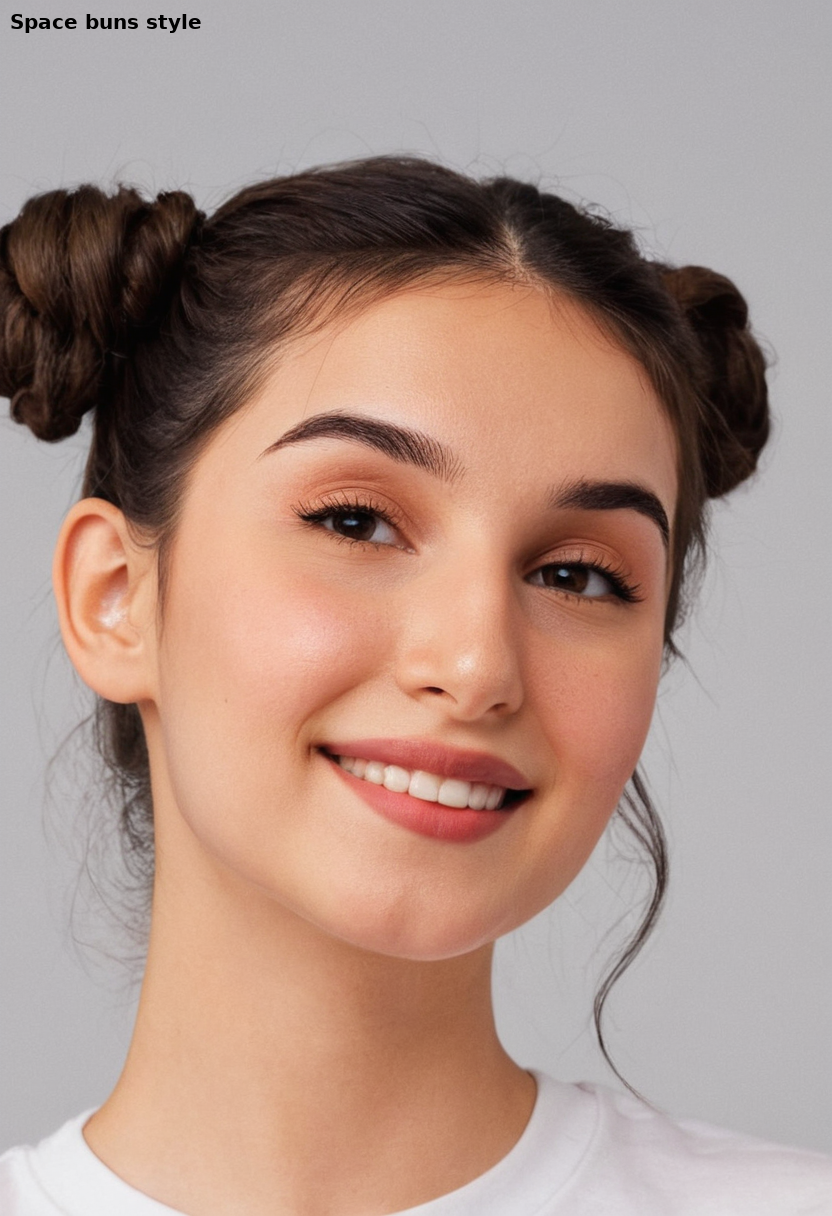

In [245]:
prompts_white = {
    "textured_fringe_style": "textured fringe hairstyle with fading sides and whiskers, bald sides, buzzed sides, same background, high quality",
    "messy_flow_style": "messy flow hairstyle, rugged look, same background, high quality",
    "old_money_style": "old money flow hairstyle for men, rugged look, same background, high quality",
    "tapper_fade_style": "tapper fade hairstyle for men, short sides, buzzed sides, same background, high quality",
    "buzz_cut_style": "buzz cut hairstyle, same background, high quality",
    "wavy_undercut_style": "wavy undercut hairstyle, long top, very short sides, buzzed sides, fading sides, plain background, high quality",
    "pompodour_style": "pompadour hairstyle, buzzed sides, short sides, proportional, same background, high quality",
    "combover_style": "comb over hairstyle, slick back, proportional, uniform, same background, high quality, beautiful",
    "tom_boy_style": "tom boy haircut, plain background, high quality, beautiful",
    "bleached_spikes_style": "bleached spike haircut, plain background, high quality, beautiful",
    "bob_style": "bob cut hairstyle, plain background, high quality, beautiful",
    
}


prompts_black = {
    "afro_style": "afro hair, rugged look, plain background, high quality",
    "twists_style": "twists hairstyle, long hair, rugged look, plain background, high quality",
    "burst_fade_style": "burst fade hairstyle, long curly hair++, yellow colored, rugged look, plain background, high quality",
    "dreads_style": "dreadlock hairstyle, long dreadlocks, dreadlocks+++, individual locks++, plain background, studio background, high quality",
    "coils_style": "coils hairstyle, curly hair, coil twists++, plain background, high quality",
    "bald": "bald hairstyle, plain brackground, high quality",
    "spiky_locs": "locs hairstyle, spiky, long, plain background, high quality",
    "fade_afro_style": "flat top hair, long hair, plain background, high quality",
    
}


prompts_woman = {
    "butterfly_cut": "butterfly cut hairstyle, big volume, layers, very long hair, plain background, high quality",
    "layered_bob_style": "layered bob haircut, layers, plain background, high quality",
    "pixie_cut_style": "pixie haircut, plain background, high quality",
    "birkin_bangs_style": "birkin bangs hairstyle, big volume, layers, very long hair, plain background, high quality",
    "curtain_bangs_style": "curtain bangs hairstyle, big volume, layers, very long hair, plain background, high quality",
    "straight_bangs_style": "straight bangs hairstyle, very long hair, plain background, high quality",
    "wolf_cut_style": "wolf cut, shaggy mullet, textured and choppy layers, long hair, plain background, high quality",
    "wavy_lob_style": "wavy lob hairstyle, long hair, plain background, high quality",
    "sleek_middle_part_style": "sleek middle part hairstyle, combed, sleek, long hair, plain background, high quality",
    "space_buns_style": "space buns hairstyle, two buns, both buns visible, plain background, high quality",
    # "modern_shag_style": "modern shag hairstyle, wavy hair, layers, wispy bangs, long, messy, plain background, high quality",
    
}
# A young man with a stylish middle part undercut hairstyle. The top of his hair is long, parted neatly in the middle, and flows down symmetrically on either side, framing his face. The sides and back are sharply undercut, contrasting with the longer top. His hair has a natural shine, suggesting light use of styling products. The overall look is clean and modern, with a slight vintage touch reminiscent of 1990s fashion. The background is simple, ensuring the focus remains on his hairstyle.
# pose_images = pose_images[0:1]

compel_proc = Compel(
    tokenizer=[pipe_maket.tokenizer, pipe_maket.tokenizer_2] , 
    text_encoder=[pipe_maket.text_encoder, pipe_maket.text_encoder_2], 
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, 
    requires_pooled=[False, True]
)
for key, prompt in prompts_woman.items():

    main_prompt = f"hair photography of a woman with {prompt}, plain t-shirt, light background, slightly smiling, relaxed facial expression" #"hair photography of a man with bowl cut hairstyle, photo studio, light background, slightly smiling, closed mouth"
    negative_prompt = "monochrome, lowres, bad anatomy, blurry, teeth, nude, naked, skin, frowning, open mouth, jewelry, visible teeth++, open mouth, hands"
    
    seeds = [40, 44, 38, 46]
    
    all_images = []
    for i in range(len(pose_images)):
        print(main_prompt)
        prompt_embeds, prompt_pooled_embeds = compel_proc(main_prompt)
        negative_prompt_embeds, negative_prompt_pooled_embeds = compel_proc(negative_prompt)

        images = generate(
            ip_model,
            prompt_embeds=prompt_embeds,
            prompt_pooled_embeds=prompt_pooled_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            negative_prompt_pooled_embeds=negative_prompt_pooled_embeds,
            width=832, height=1216, 
            seed = 42,
            image = pose_images[i],
            faceid_embeds = faceid_embeds, 
            scale = 0.7,
            num_samples= 1, 
            guidance_scale=2,
            controlnet_conditioning_scale=0.3,
            num_inference_steps=30
        )
        all_images+=images

        image = add_text(images[0], key)
        
        image.save(f"maket_woman/out_{key}_{i}.png")

image

In [1]:
# maket_paths = glob.glob("maket_woman/out_*")
# print(maket_paths)
# maket_images = [Image.open(im) for im in maket_paths]
# grid = make_image_grid(maket_images, len(maket_images)//len(pose_images), len(pose_images))
# grid.save("grid_2.png")
# grid

In [33]:


# Load the image
image_path = "maket/out_bob_0.png"
image = Image.open(image_path)

# Initialize ImageDraw


# Save the edited image
output_path = "output_image.jpg"
image.save(output_path)

### Segmenting background and hair

In [58]:
DESIRED_HEIGHT = 256
DESIRED_WIDTH = 256

HAIR_LABEL = 1
BACKGROUND_LABEL = 0
BG_COLOR = (0, 0, 0) # gray
MASK_COLOR = (255, 255, 255) # white

model_path_hair = "./models/hair_segmenter.tflite"
model_path_selfie = "./models/selfie_segmenter.tflite"
multi_label = "./models/selfie_multiclass_256x256.tflite"

BaseOptions = mp.tasks.BaseOptions
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode


I0000 00:00:1718751630.937513    5497 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718751630.954452    6587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1718751631.087527    5497 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718751631.096708    6602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1216, 832, 3)
(1216, 832, 3)


I0000 00:00:1718751631.226837    5497 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718751631.235595    6612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1216, 832, 3)


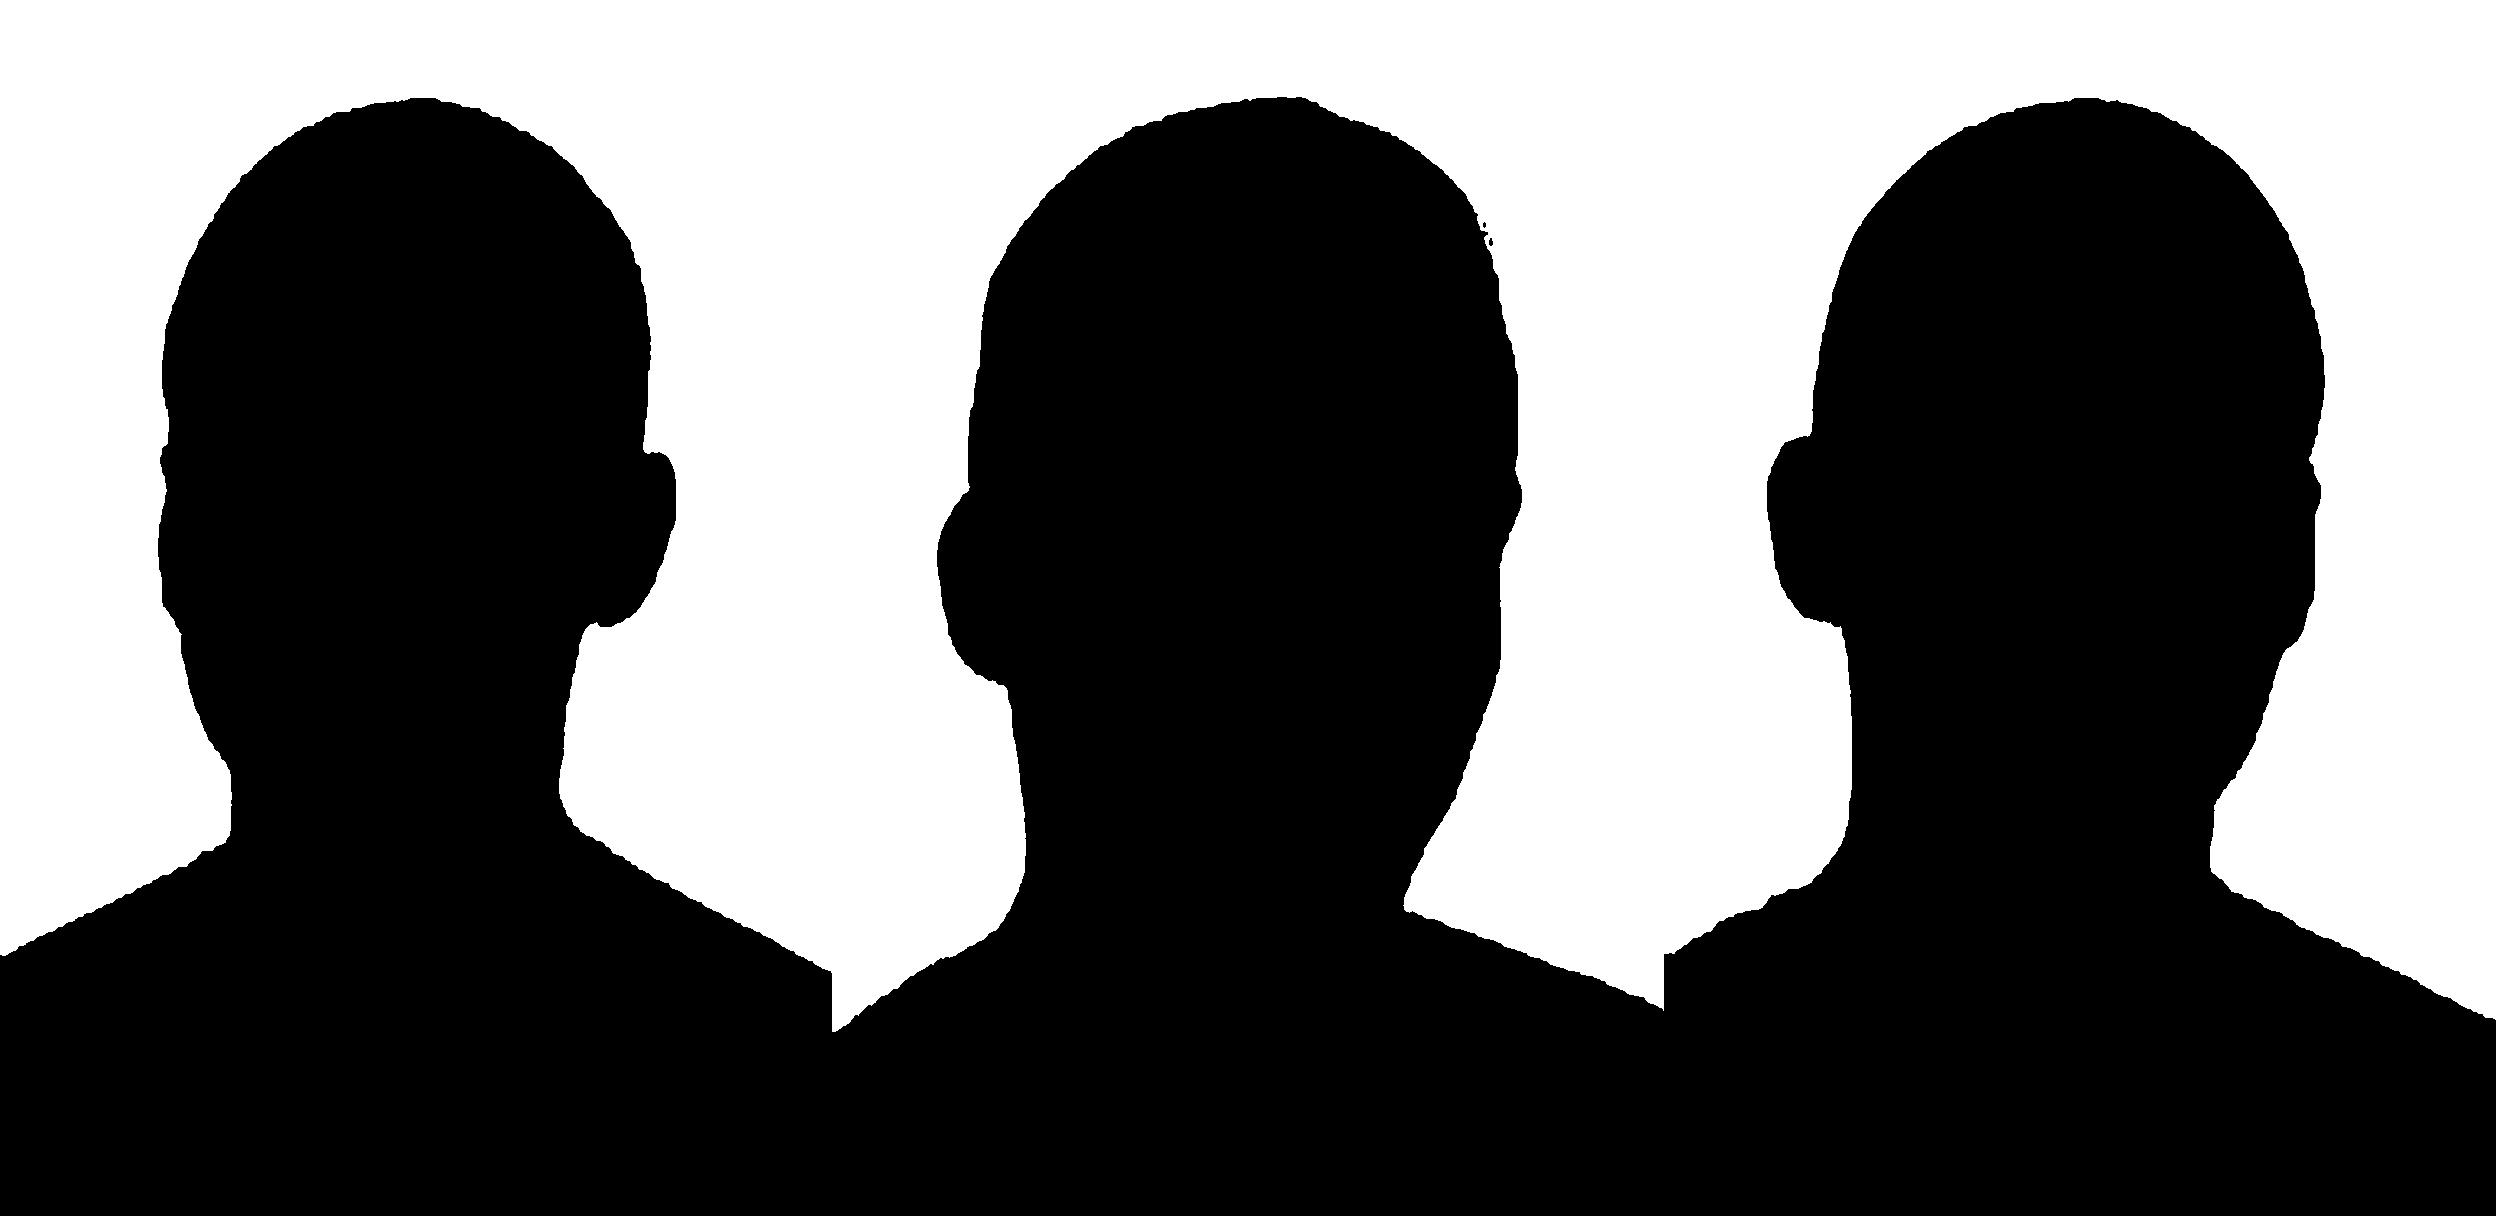

In [60]:
background = segment(model_path_selfie, maket_paths, BACKGROUND_LABEL)
background = [255-bg for bg in background]
background_masks = [Image.fromarray(bg) for bg in background]
make_image_grid(background_masks, 1, len(background_masks))

I0000 00:00:1718751633.833154    5497 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718751634.186877    6622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1216, 832, 3)


I0000 00:00:1718751634.502299    5497 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718751634.527251    6632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1216, 832, 3)


I0000 00:00:1718751634.851012    5497 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1718751634.870117    6642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(1216, 832, 3)


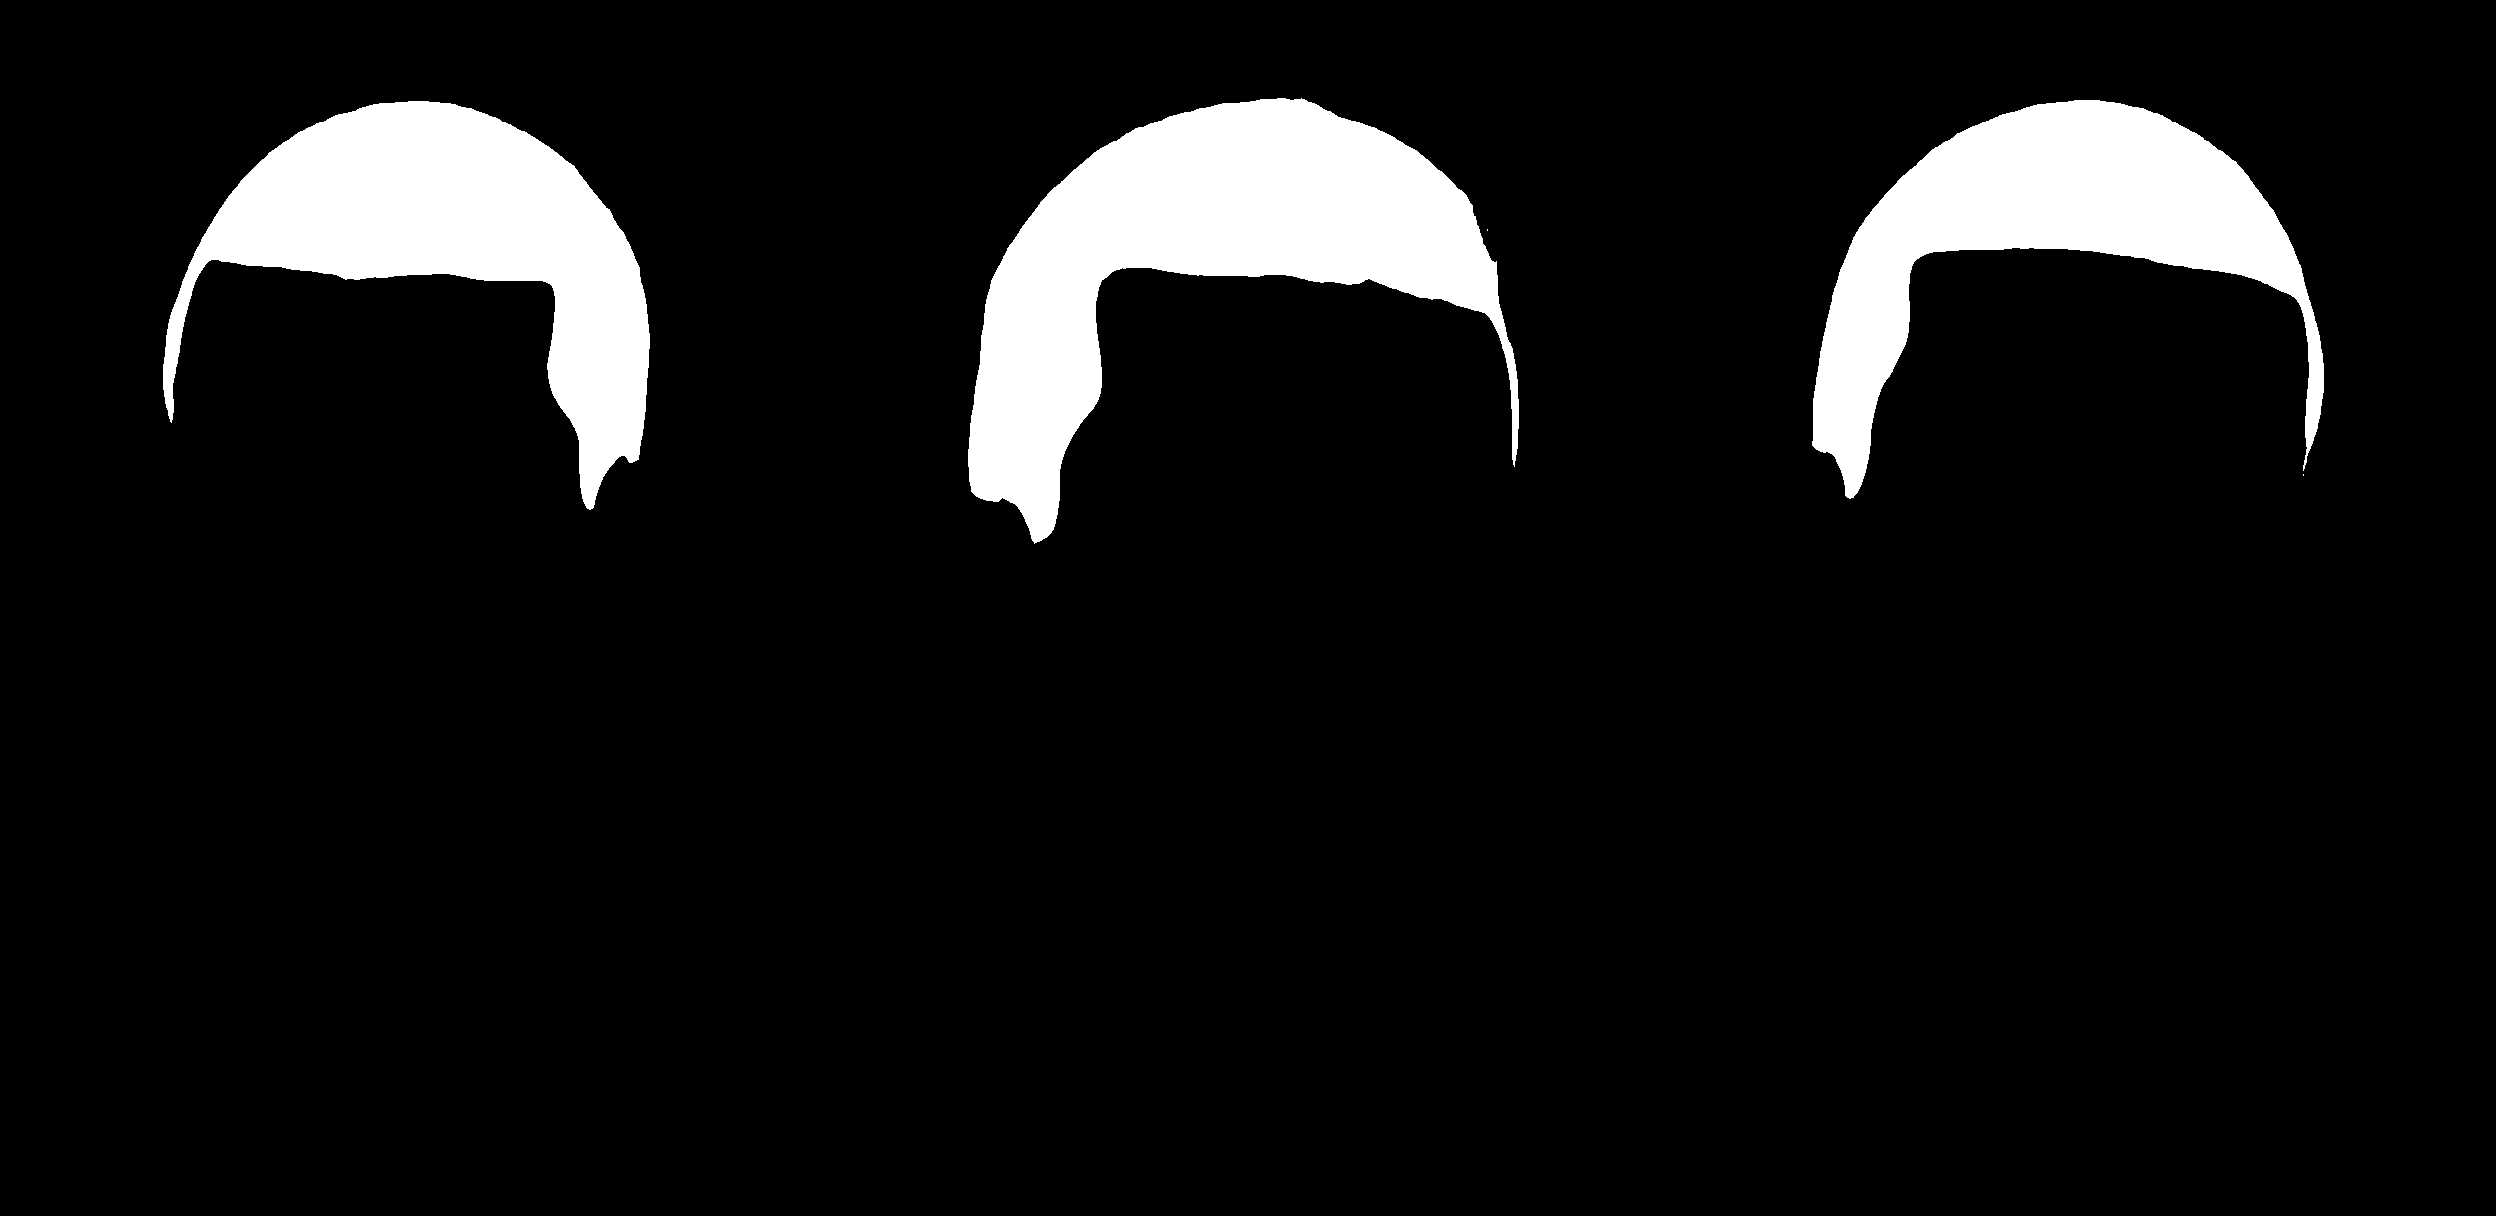

In [61]:
hair = segment(multi_label, maket_paths, HAIR_LABEL)

hair_masks = [Image.fromarray(hr) for hr in hair]
make_image_grid(hair_masks, 1, len(hair_masks))

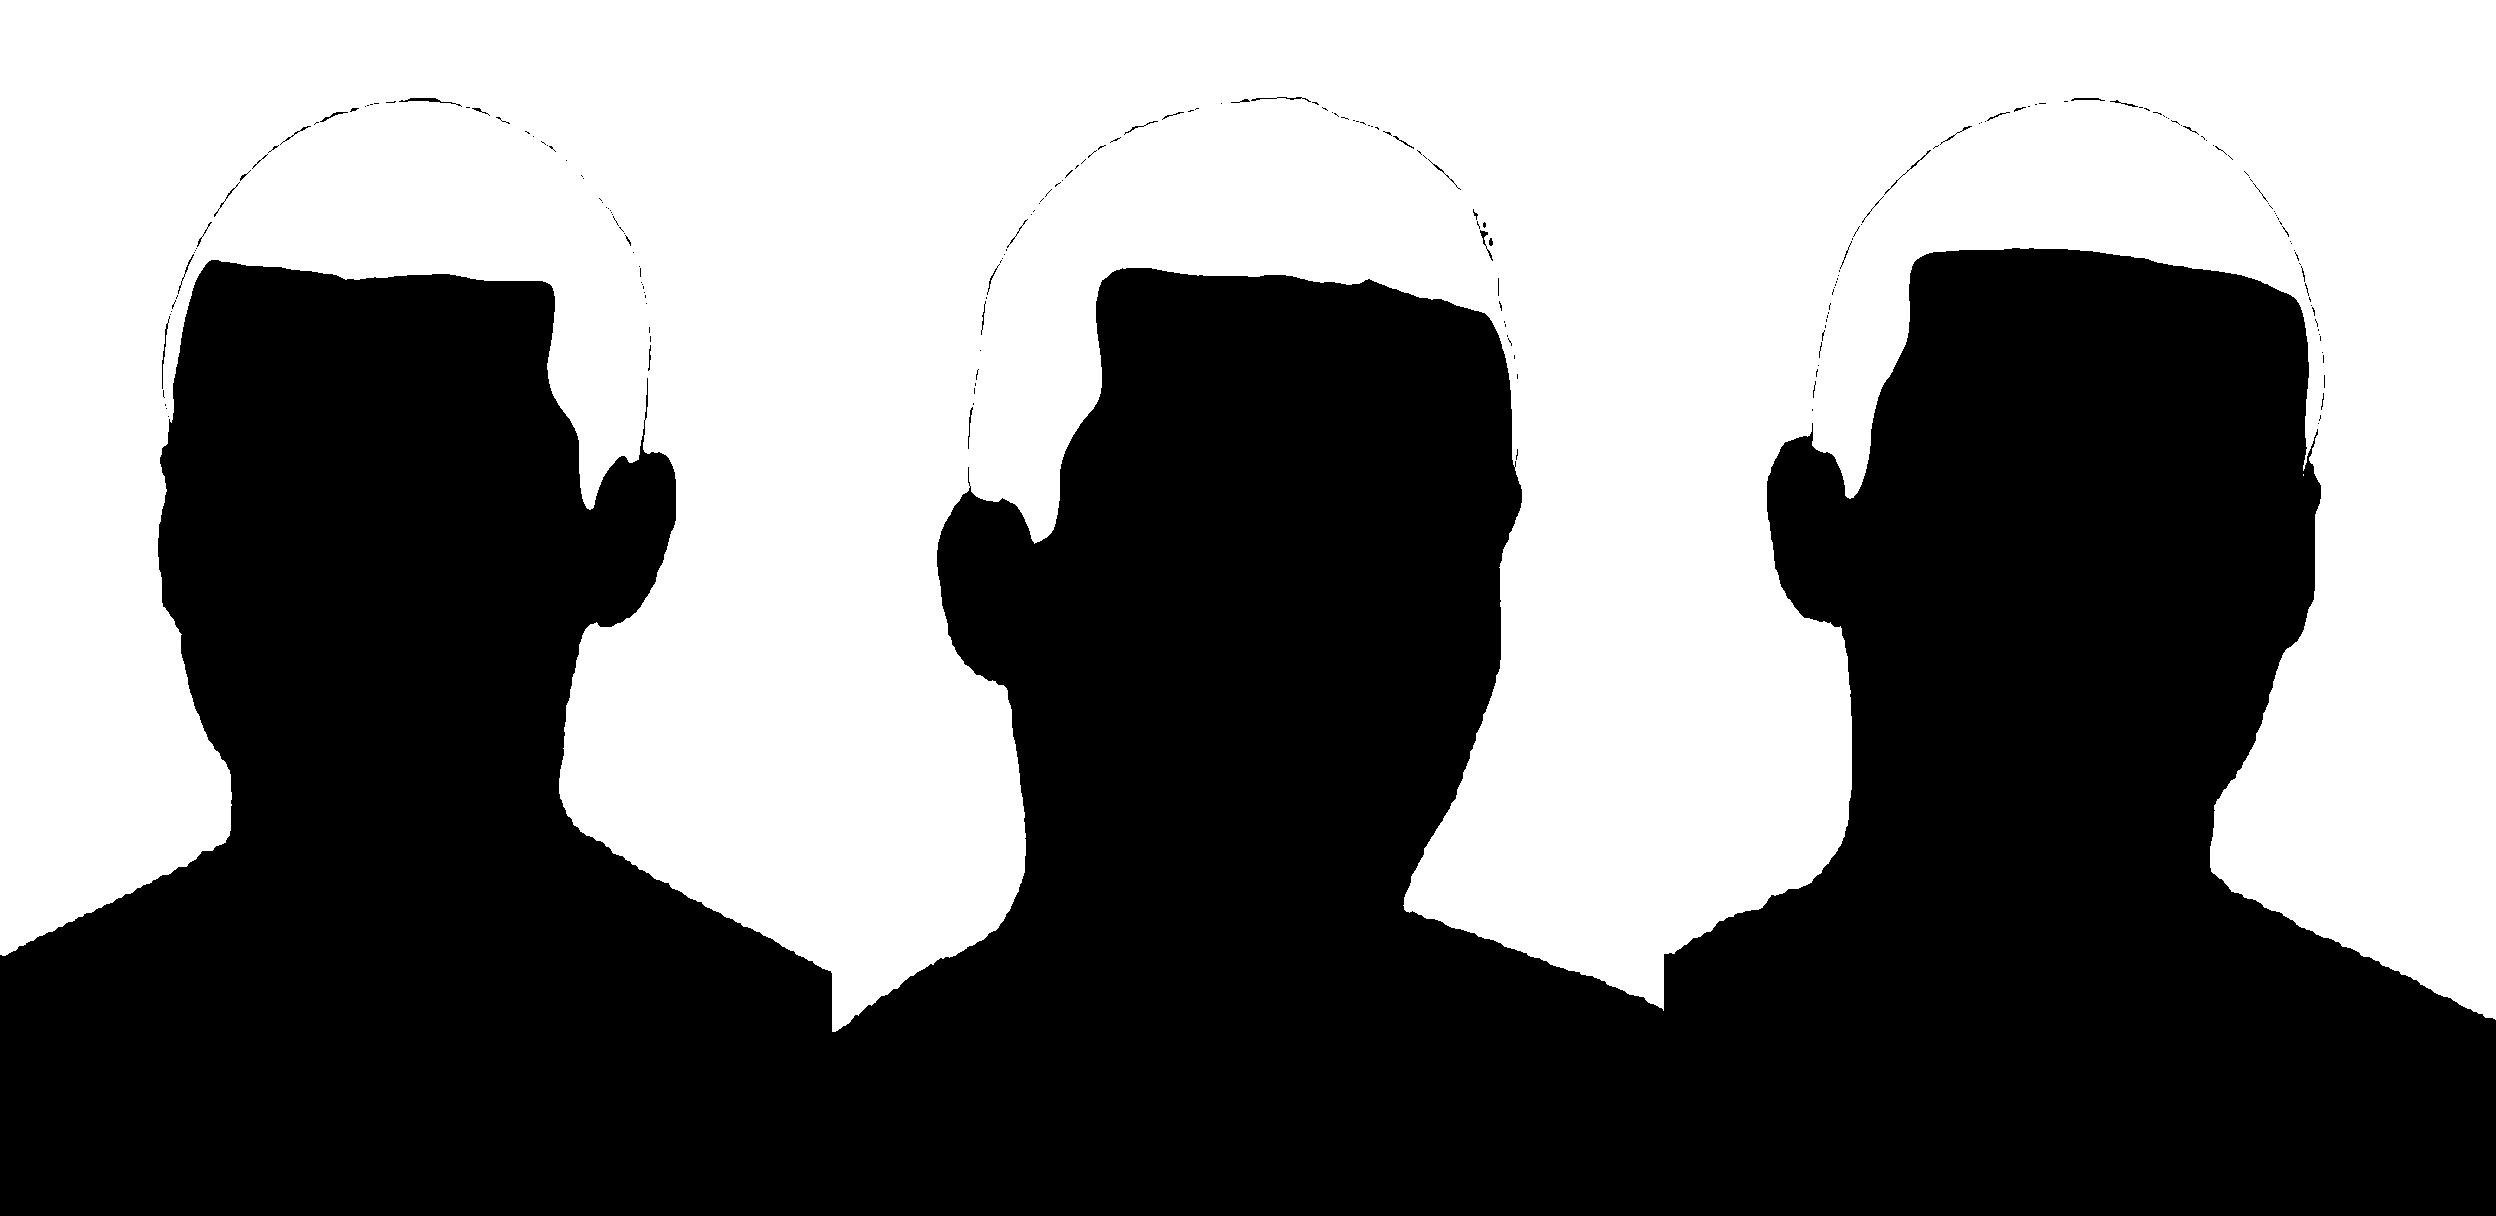

In [62]:
joint = []

for i in range(len(background_masks)):
    joint.append(background[i] + hair[i])
joint_mask = [Image.fromarray(j) for j in joint]
make_image_grid(joint_mask, 1, len(joint_mask))

0 255
0 255
0 255


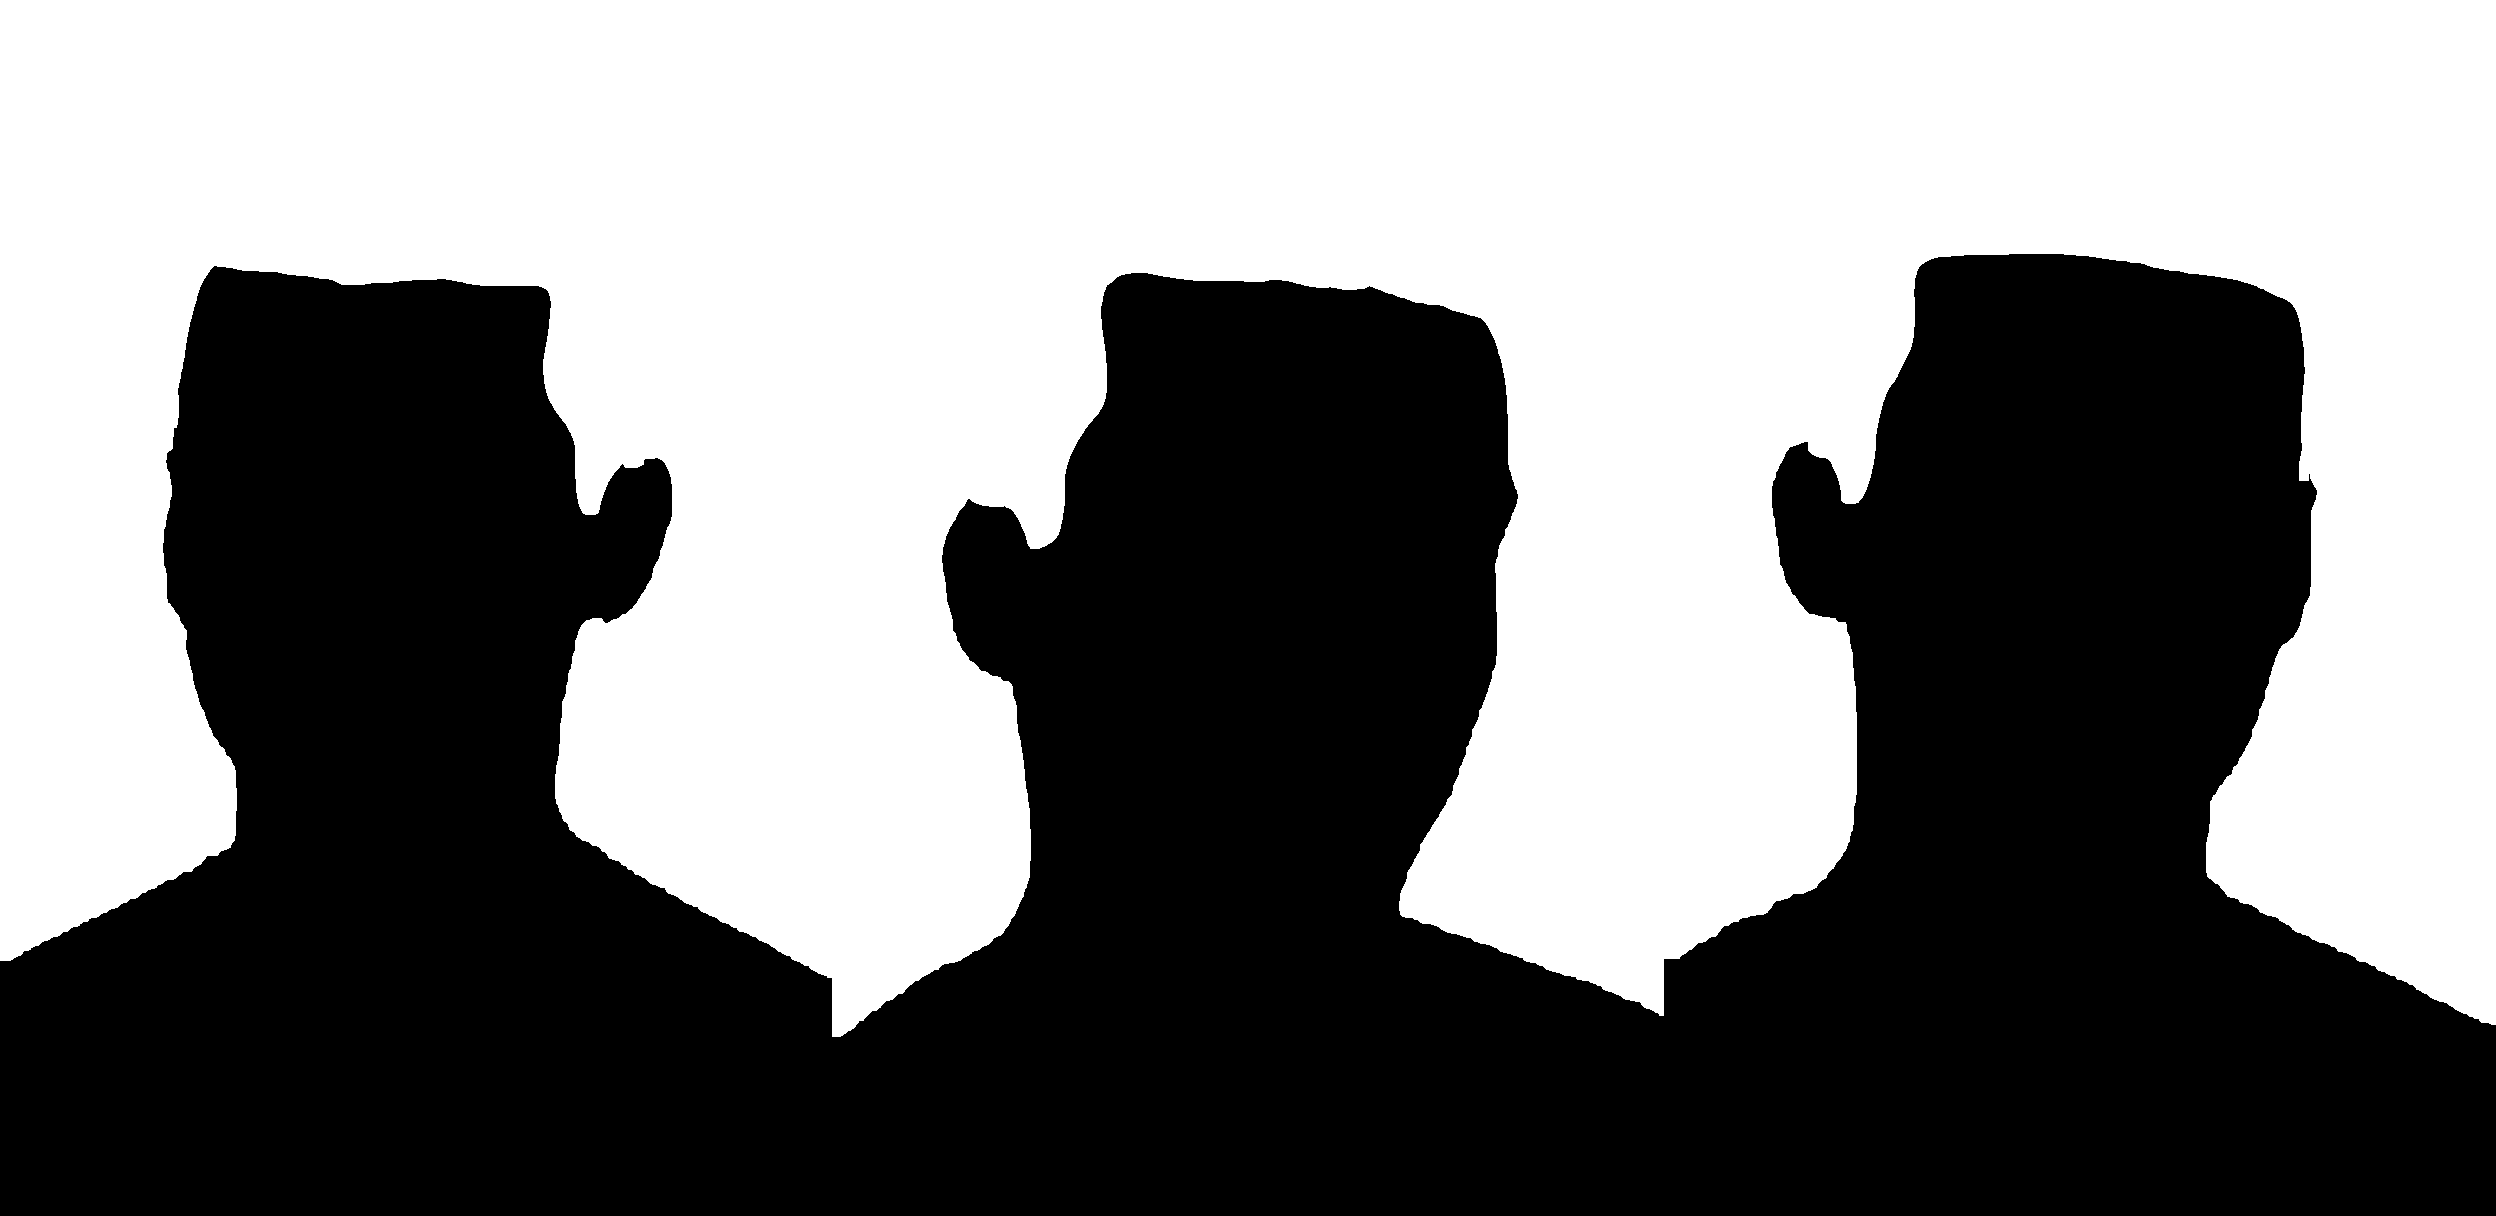

In [64]:
expanded_masks = []

for m in joint_mask:

    blurred_mask = expand_white_area(m, expansion_size=10) #blur_mask(mask_image, 10)
    expanded_masks.append(blurred_mask)

make_image_grid(expanded_masks, 1, len(expanded_masks))

In [90]:
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# results = face_mesh.process(image_rgb)

# # Check if landmarks are detected
# if results.multi_face_landmarks:
#     for face_landmarks in results.multi_face_landmarks:
#         # Get the coordinates of the eyebrows
#         eyebrow_points = [face_landmarks.landmark[i] for i in range(70, 103)]  # Eyebrow landmark indices in MediaPipe Face Mesh

#         # Convert normalized coordinates to pixel values
#         h, w, _ = image.shape
#         eyebrow_coords = [(int(pt.x * w), int(pt.y * h)) for pt in eyebrow_points]

#         # Create a mask for the area above the eyebrows
#         mask = np.zeros((h, w), dtype=np.uint8)

#         # Define a polygon that covers the area above the eyebrows
#         polygon = np.array([[0, 0], [w, 0]] + eyebrow_coords + [[0, h]], np.int32)
#         cv2.fillPoly(mask, [polygon], 255)

#         # Apply the mask to your image
#         masked_image = cv2.bitwise_and(image, image, mask=mask)

#         # Optionally, visualize the mask and the result
#         cv2.imshow('Mask', mask)
#         cv2.imshow('Masked Image', masked_image)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
# else:
#     print("No face landmarks detected.")

# # Release the face mesh model
# face_mesh.close()

In [75]:
model = "stabilityai/your-stable-diffusion-model"
vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae")

pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    # base_model_path,
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    # variant="fp16",
    # controlnet=controlnet,
    feature_extractor=None,
    # vae=vae
    # safety_checker=None
    
).to(device)

# scheduler = 'DPM++SDEKarras'
# pipe.scheduler = SCHEDULERS[scheduler].from_config(pipe.scheduler.config)
# load ip-adapter
# ip_model = IPAdapterFaceIDXL(pipe, ip_ckpt, device, num_tokens=16, n_cond=2)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [92]:
expanded_masks[0].size, maket_images[0].size

((832, 1216), (832, 1216))

  0%|          | 0/19 [00:00<?, ?it/s]

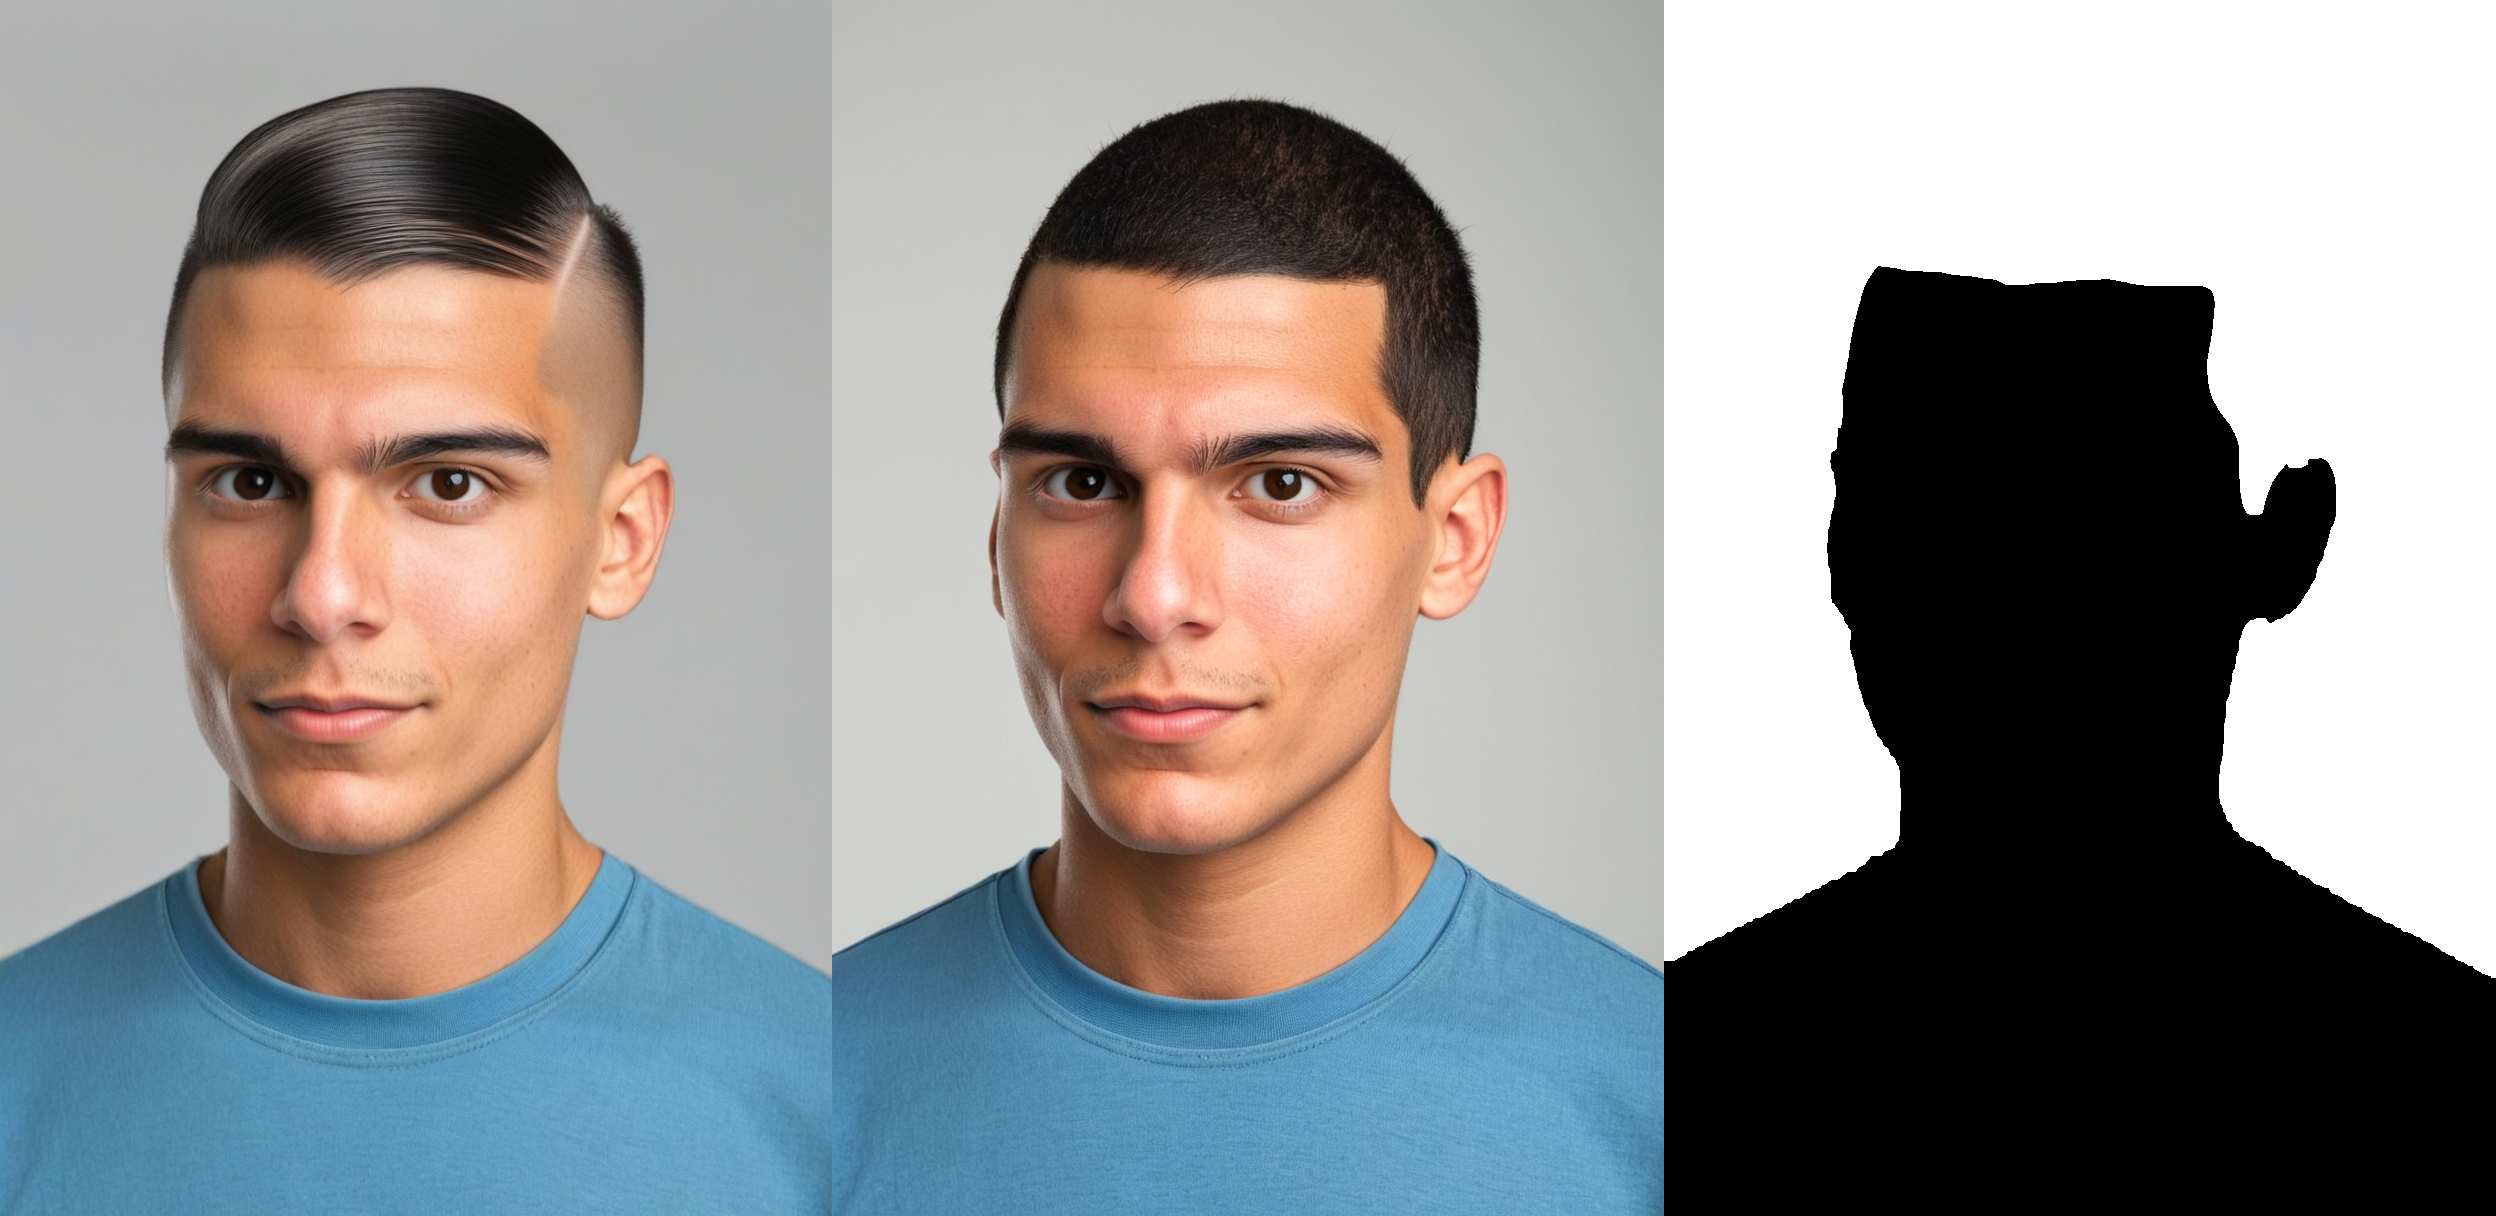

In [90]:
prompts = {
    "textured_fringe": "textured fringe hairstyle with fading sides and whiskers, bald sides, buzzed sides, same background, high quality, plain t-shirt",
    "messy_flow": "messy flow hairstyle, rugged look, same background, high quality",
    "old_money": "old money flow hairstyle for men, rugged look, same background, high quality",
    "tapper_fade": "tapper fade hairstyle for men, short sides, buzzed sides, same background, high quality",
    "buzz_cut": "buzz cut hairstyle, same background, high quality",
    "wavy_undercut": "wavy undercut hairstyle, same background, high quality",
    "pompodour": "pompadour hairstyle, proportional, same background, high quality",
    "combover": "comb over hairstyle, proportional, uniform, same background, high quality, beautiful",
    "middle_undercut": "middle part undercut hairstyle. hair parted neatly in the middle, and flows down symmetrically on both sides. plain background, high quality, beautiful"
    
    
    
}

negative_prompt = "deformed ears"


input_image = maket_images[0]
mask = expanded_masks[0]
images = pipe(
    prompt=prompts['middle_undercut'], 
    negative_prompt=negative_prompt, 
    image=input_image,
    num_samples=1, 
    num_inference_steps=20, 
    seed=42, 
    guidance_scale=8,
    width = input_image.width,
    height = input_image.height,
    # strength=,
    # control_image=openpose_image,
    # controlnet_conditioning_scale=0.1,
    mask_image = mask, 
    # guidance_scale=8.0
).images

make_image_grid(images + [input_image, mask], 1, 1+2)


In [22]:
swapper = insightface.model_zoo.get_model('models/inswapper_128.onnx', download=False, download_zip=False)

def run_face_swap(source_image_path, target_image_path, save_path):

    img1 = cv2.imread(source_image_path)
    img2 = cv2.imread(target_image_path)

    face1 = app.get(img1)[0]
    face2 = app.get(img2)[0]

    img2_ = img2.copy()
    out = swapper.get(img2_, face2, face1, paste_back=True)
    Image.fromarray(
        cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    
    ).save(save_path)

    inference_app(
        save_path,
        background_enhance = True,
        face_upsample = True,
        upscale = 2,
        codeformer_fidelity = 0.8
    )

    shutil.copy("output/out.png", save_path)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


2024-06-15 09:13:39.426209848 [E:onnxruntime:Default, provider_bridge_ort.cc:1744 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1426 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.11: cannot open shared object file: No such file or directory



inswapper-shape: [1, 3, 128, 128]


In [23]:
make_image_grid(images, 1, num_samples).save("output_fade.png")

In [27]:
# run_face_swap(best_image, "output_fade.png", "output_fade2.png")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

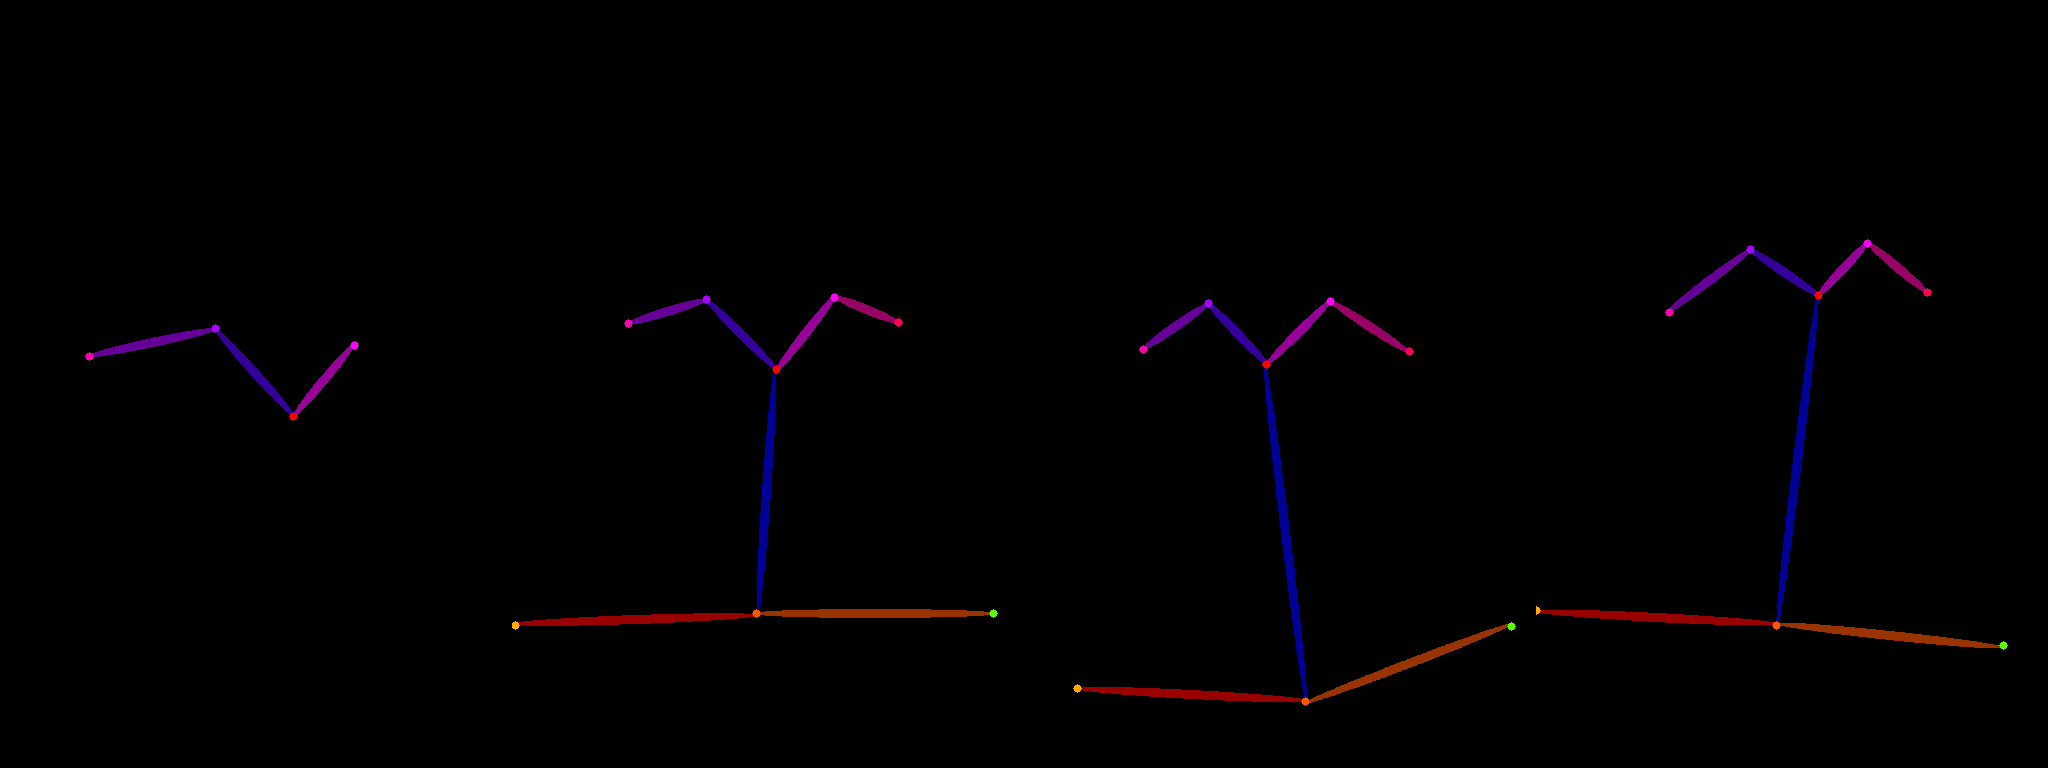

In [146]:
make_image_grid(pose_images, 1, 4)

NameError: name 'mp' is not defined

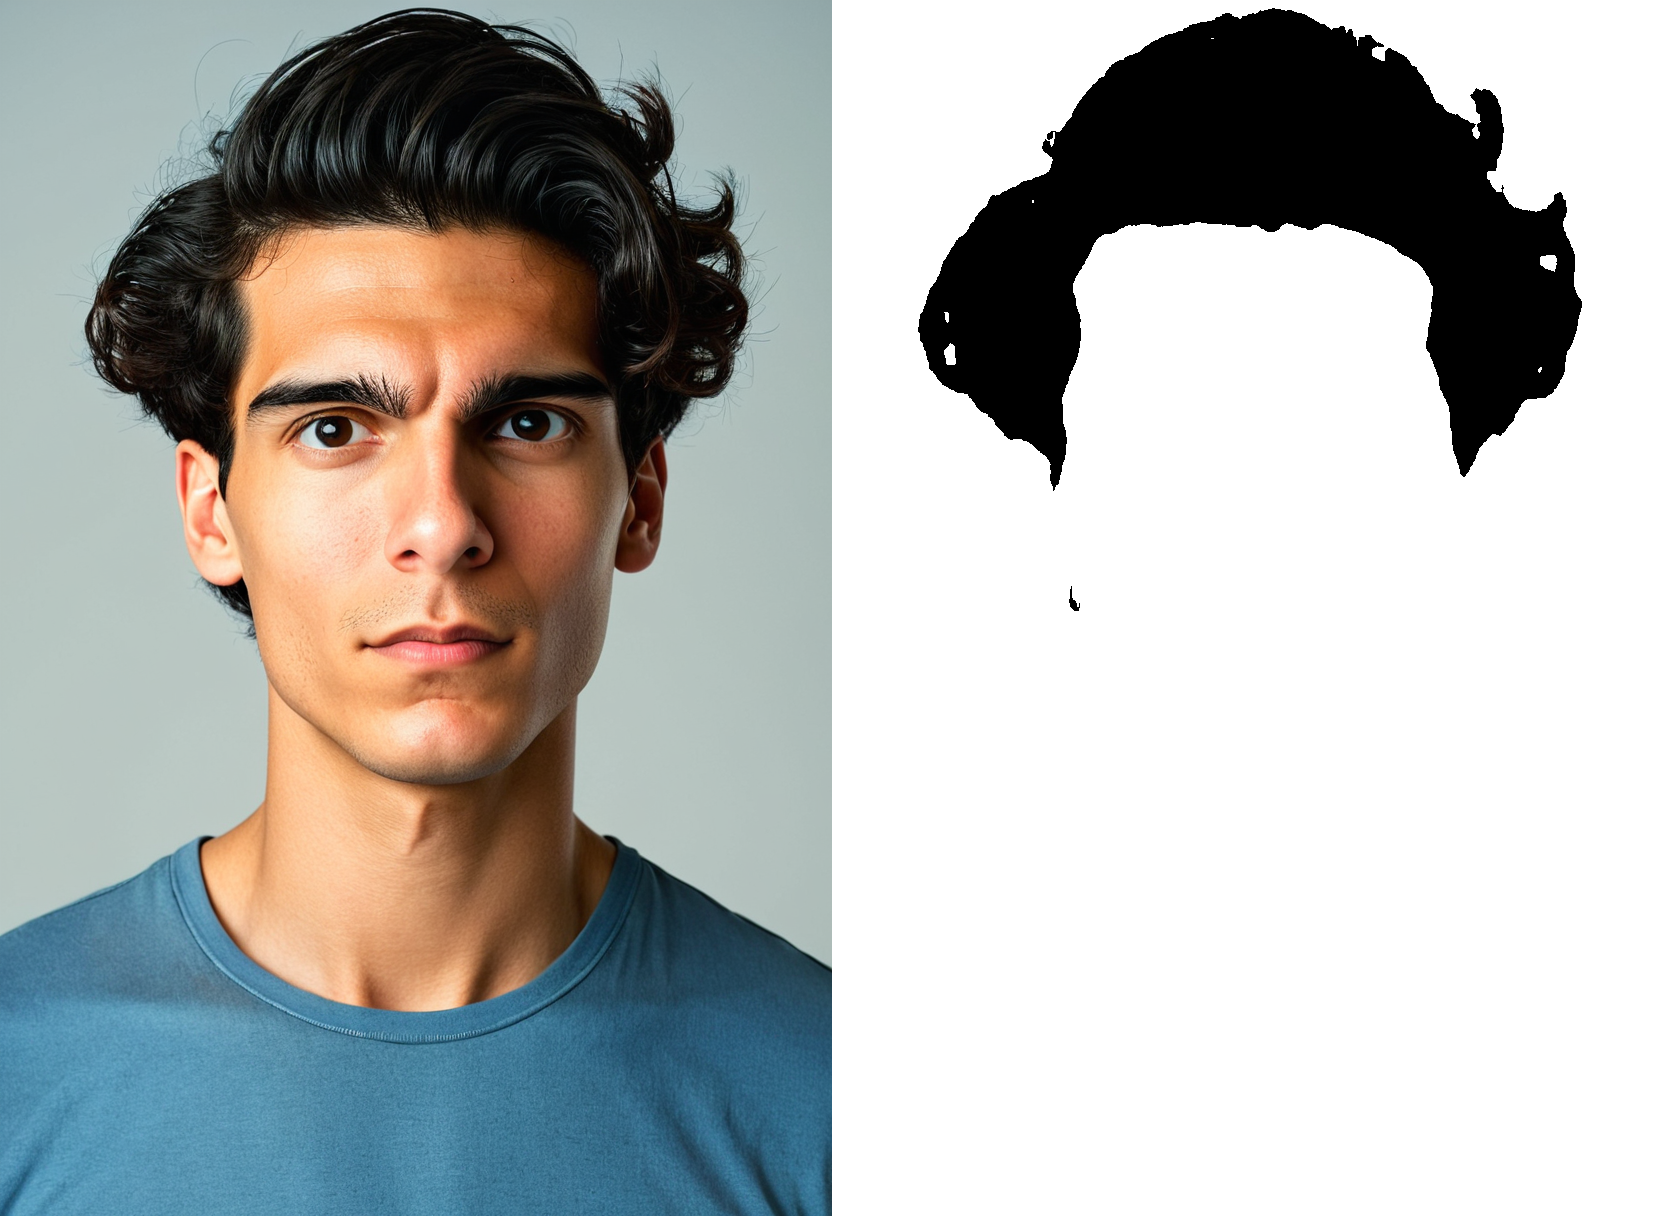

In [152]:
make_image_grid([Image.open("out.png"),  Image.fromarray(outputs[0])], 1, 2)

In [121]:
Image.fromarray(outputs[0]).save("out_mask.png")

In [225]:
import glob


print(glob.glob("output_*"))
images = [Image.open(t) for t in glob.glob("output_*")] 
make_image_grid(images, 2, 4).save("grid.png")

['output_fade.png', 'output_fringe.png', 'output_messy_flow.png', 'output_old_flow.png', 'output_wavy.png', 'output_bowl.png', 'output_buzz.png', 'output_pomp.png']


In [ ]:
# messy flow - "hair photography of a man with 'messy flow' hairstyle, rugged look, photo studio, light background, slightly smiling"
# fringe -  "hair photography of a man with textured fringe hairstyle, fading sides, photo studio, light background, slightly smiling, closed mouth"
#negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, teeth, nude, naked, hands, skin, frowning, open shoulders, open arms, beard, hair on forehead, open mouth"